In [1]:
# imports
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
from time import time
from scipy import stats
import json

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import make_scorer, roc_auc_score, log_loss, accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix

from IPython.display import display, Math, Latex

In [2]:
df = pd.read_csv('../Group16_Phase3/application_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
y = df['TARGET']
x = df.drop(columns='TARGET')

### Building Logistic Regression baseline pipeline

In [4]:
results = pd.DataFrame(columns=["ExpID", "Cross fold train accuracy", "Test Accuracy", "Validation Accuracy", "AUC", "Train Time(s)", "Test Time(s)", "Validation Time(s)","Experiment description"])

def pct(x):
    return round(100*x,1)


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values


def returnModel(x,y,results,description_text):
    num_attribs = []
    cat_attribs = []

    for col in x.columns.tolist():
        if x[col].dtype in (['int','float']):
            num_attribs.append(col)
        else:
            cat_attribs.append(col)
            
    le_dict = {}
    for col in x.columns.tolist():
        if df[col].dtype == 'object':
            le = LabelEncoder()
            x[col] = x[col].fillna("NULL")
            x[col] = le.fit_transform(x[col])
            le_dict['le_{}'.format(col)] = le

    num_pipeline =Pipeline([('selector',DataFrameSelector(num_attribs)),
                           ('scaler', StandardScaler()),
                          ('imputer', SimpleImputer(strategy = 'median'))
                           ])
    
    
    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    
    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ]) 
    
    np.random.seed(42)
    full_pipeline_with_predictor = Pipeline([
            ("preparation", num_pipeline),
            ("linear", LogisticRegression(random_state=42))
        ])
            
    # split 20% test data with random seed set to 42 for correct results
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    print("train data set: ")
    print(x_train.shape,y_train.shape)
    print("test data set: ")
    print(x_test.shape,y_test.shape)
    print("validation data set: ")
    print(x_valid.shape,y_valid.shape)
    
            
    start = time()
    full_pipeline_with_predictor.fit(x_train, y_train)
    np.random.seed(42)

    cv30Splits = ShuffleSplit(n_splits = 30, test_size = 0.3, random_state = 0)
    logit_scores = cross_val_score(full_pipeline_with_predictor, x_train, y_train, cv = cv30Splits)              
    logit_score_train = logit_scores.mean()
    train_time = np.round(time() - start, 4)

    # Time and score test predictions
    start = time()
    logit_score_test  = full_pipeline_with_predictor.score(x_test, y_test)
    test_time = np.round(time() - start, 4)
    
    start = time()
    logit_score_valid  = full_pipeline_with_predictor.score(x_valid, y_valid)
    valid_time = np.round(time() - start, 4)
    
    AUC = roc_auc_score(y_test,full_pipeline_with_predictor.predict(x_test))
    print("AUC is {}".format(AUC))
    print("\n............\n")
    print("Confusion Matrix: {}".format(confusion_matrix(y_test, full_pipeline_with_predictor.predict(x_test))))
    
    no_of_inputs = x.shape[1]
    
    temp_df = pd.DataFrame()
    temp_df = temp_df.append(pd.Series(["Baseline with {} inputs".format(no_of_inputs), pct(logit_score_train), pct(logit_score_test), pct(logit_score_valid),
                  AUC, train_time, test_time, valid_time, "{} - Untuned LogisticRegression".format(description_text)]),ignore_index=True)
    temp_df.columns = results.columns
    
    results = results.append(temp_df,ignore_index=True)
    
    return le_dict, full_pipeline_with_predictor, results

### Loss function used (data loss and regularization parts) in latex


source: https://tex.stackexchange.com/questions/517834/how-to-define-loss-function-in-latex

In [5]:
display(Math(r'[L_\varepsilon(y,f(x,w))=\max\{0, |y-f(x,w)|-\varepsilon\}]'))

<IPython.core.display.Math object>

In [6]:
le_dict, full_pipeline_with_predictor, results = returnModel(x,y,results,"Unbalanced Dataset")

train data set: 
(196806, 121) (196806,)
test data set: 
(61503, 121) (61503,)
validation data set: 
(49202, 121) (49202,)
AUC is 0.5036433706059472

............

Confusion Matrix: [[56509    45]
 [ 4909    40]]


In [7]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,Validation Accuracy,AUC,Train Time(s),Test Time(s),Validation Time(s),Experiment description
0,Baseline with 121 inputs,92.0,91.9,91.8,0.503643,104.8321,0.1061,0.0758,Unbalanced Dataset - Untuned LogisticRegression


# Submission 1
Checking across test dataset

In [8]:
test_data_set = pd.read_csv('../Group16_Phase3/application_test.csv')
test_data_set.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for col in test_data_set.columns.tolist():
    for le in le_dict:
        if col in le:
            test_data_set[col] = le_dict[le].fit_transform(test_data_set[col])

In [10]:
output_data = test_data_set[['SK_ID_CURR']]
output_data['TARGET'] = pd.Series(full_pipeline_with_predictor.predict(test_data_set).tolist())

In [11]:
output_data['TARGET'].value_counts()

0    48676
1       68
Name: TARGET, dtype: int64

In [12]:
output_data.to_csv('./output.csv', index=False)

# Improving the AUC

### Balancing the dataset and running the same baseline model

### Approach 1

In [12]:
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [13]:
final_data = df[df['TARGET']==1]
final_data = final_data.append(df[df['TARGET']==0].reset_index(drop=True).sample(n = 50000))
print(final_data.shape)
final_data.head()

(74825, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
x = final_data.drop(columns='TARGET')
y = final_data['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)
print(x_train.shape,y_train.shape)

(59860, 121) (59860,)


In [15]:
le_dict, full_pipeline_with_predictor, results = returnModel(x,y,results,"50000 non-defaulters Balanced Dataset")

train data set: 
(47888, 121) (47888,)
test data set: 
(14965, 121) (14965,)
validation data set: 
(11972, 121) (11972,)
AUC is 0.6232512922394526

............

Confusion Matrix: [[8941 1110]
 [3160 1754]]


In [16]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,Validation Accuracy,AUC,Train Time(s),Test Time(s),Validation Time(s),Experiment description
0,Baseline with 121 inputs,92.0,91.9,91.8,0.502537,146.9194,0.1387,0.1223,Unbalanced Dataset - Untuned LogisticRegression
1,Baseline with 121 inputs,71.2,71.5,71.9,0.623251,26.9970,0.0328,0.0408,50000 non-defaulters Balanced Dataset - Untune...


# Submission 2
Checking across test dataset

In [17]:
output_data = test_data_set[['SK_ID_CURR']]
output_data['TARGET'] = pd.Series(full_pipeline_with_predictor.predict(test_data_set).tolist())

In [18]:
output_data['TARGET'].value_counts()

0    42160
1     6584
Name: TARGET, dtype: int64

In [19]:
output_data.to_csv('./output_submission_1.csv', index=False)

### Approach 2

In [20]:
final_data = df[df['TARGET']==1]
final_data = final_data.append(df[df['TARGET']==0].reset_index(drop=True).sample(n = 75000))
print(final_data.shape)
final_data.head()

(99825, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,2.0
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,4.0
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
x = final_data.drop(columns='TARGET')
y = final_data['TARGET']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, shuffle=True, random_state=42)
print(x_train.shape,y_train.shape)

(79860, 121) (79860,)


In [22]:
le_dict, full_pipeline_with_predictor, results = returnModel(x,y,results,"75000 non-defaulters Balanced Dataset")

train data set: 
(63888, 121) (63888,)
test data set: 
(19965, 121) (19965,)
validation data set: 
(15972, 121) (15972,)
AUC is 0.5695009389246085

............

Confusion Matrix: [[14242   734]
 [ 4051   938]]


In [23]:
results

,ExpID,Cross fold train accuracy,Test Accuracy,Validation Accuracy,AUC,Train Time(s),Test Time(s),Validation Time(s),Experiment description
0,Baseline with 121 inputs,92.0,91.9,91.8,0.502537,146.9194,0.1387,0.1223,Unbalanced Dataset - Untuned LogisticRegression
1,Baseline with 121 inputs,71.2,71.5,71.9,0.623251,26.9970,0.0328,0.0408,50000 non-defaulters Balanced Dataset - Untune...
2,Baseline with 121 inputs,76.7,76.0,76.8,0.569501,36.4743,0.0408,0.0325,75000 non-defaulters Balanced Dataset - Untune...


# Submission 3
Checking across test dataset

In [24]:
output_data = test_data_set[['SK_ID_CURR']]
output_data['TARGET'] = pd.Series(full_pipeline_with_predictor.predict(test_data_set).tolist())

In [25]:
output_data['TARGET'].value_counts()

0    45649
1     3095
Name: TARGET, dtype: int64

In [26]:
output_data.to_csv('./output_submission_2.csv', index=False)

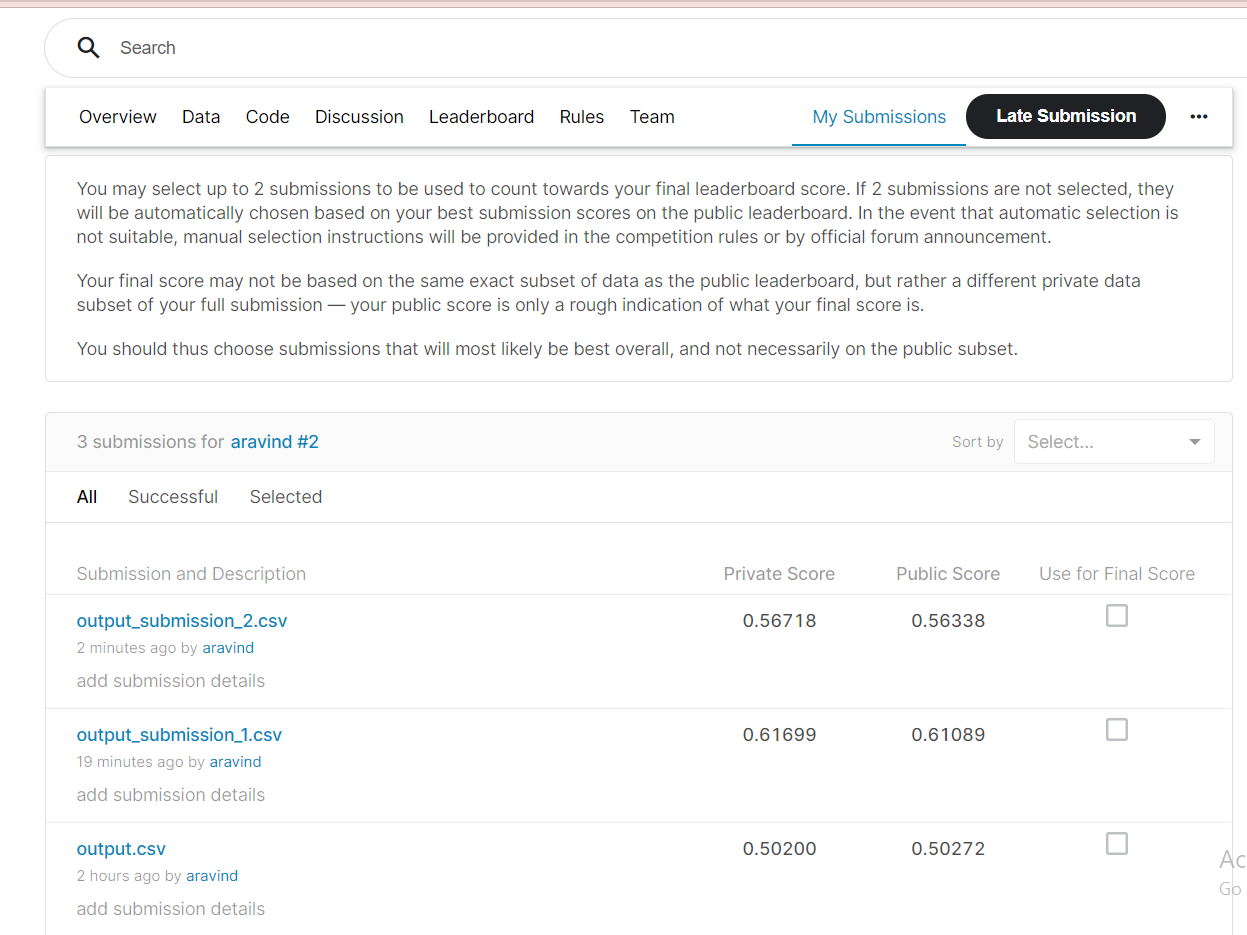